In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import strip_non_alphanum
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import strip_punctuation
from gensim.utils import lemmatize

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [2]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

Using TensorFlow backend.


In [3]:
with open(r"C:\Users\i516279\Desktop\NLP\ClosedWonCombined20000.json") as json_file:  
    data_cw = pd.read_json(json_file)
with open(r"C:\Users\i516279\Desktop\NLP\ClosedNotWonCombined20000.json") as json_file:  
    data_cnw = pd.read_json(json_file)
    
data_cnw=data_cnw['Next_Steps'].to_frame()
data_cw=data_cw['Next_Steps'].to_frame()

data_cnw['output']=0
data_cw['output']=1

data=data_cnw.append(data_cw)

# 1) Feature Inspection

In [4]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

In [5]:
data.isnull().sum()

Next_Steps    92
output         0
dtype: int64

In [6]:
data=data.dropna()
data=data[data.Next_Steps!='']


In [7]:
print(data.shape)
# print(data_cnw.shape)

(30494, 2)


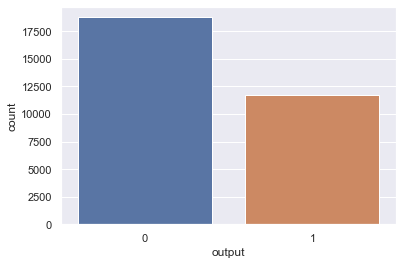

In [8]:
ax = sns.countplot(x="output", data=data)

##### As we can see the data is very imbalanced, so I will introduce SMOTE when running a ML model

In [9]:
def isEnglish(s):
    ccnt = 0
    cnt = 0
    alpha = 0.8
    asc_range = 256
    for c in s:
        if ord(c) < asc_range:
            cnt += 1
        ccnt += 1
    if ccnt == 0 or cnt / ccnt <= alpha:
        return False
    else:
        return True

In [10]:
# Convert to list
text = data['Next_Steps'].values.tolist()

# # Remove numbers
text = [re.sub('[0-9/+.?\',]+', '', str(d)) for d in text]
# nw_text= [re.sub('[0-9/+.?\',]+', '', str(d)) for d in nw_text]

# Remove new line characters
text = [re.sub('\s+', ' ', str(d)) for d in text]


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

pprint(text[0])


' - EVM - working to set EO| '


In [11]:
isEnglishlist=[]
nw_isEnglishlist=[]
for t in text:
    temp=isEnglish(t)
    isEnglishlist.append(temp)


In [12]:
mask=[i for i, j in enumerate(isEnglishlist) if j == False]
len(mask)

175

In [13]:
data.iloc[mask]

,Next_Steps,output
177,12/2 管理部 経理グループ 内嶋様、及川様向け概要説明 w/みずほ\n・既存メジャーフロ...,0
178,3/8 ADEKA大塚情報システム部長向け引継ぎ \n■先方\n・情報システム部 部長 大塚...,0
179,2019/1/31 財務経理 竹内様向け概要説明\n■参加者\n・ファイブグループ\n財務・...,0
180,2019/2/14 引継ぎ訪問 w/柳さん\n\n■先方\nコーポレート企画部 経営管理グル...,0
181,2019/4/19 AUDIジャパン IT 金川様向け概要説明\n■先方\nF＆A IT ア...,0
182,2019/5/24 二木ゴルフ 情報システム 酒井様向け概要説明\n■先方\n管理部 情報シ...,0
183,2019/4/26 中村屋経理部向け説明\n \n〇出席者 \n中村屋：経理部課長遠藤吉昭様...,0
184,2019/4/23 ネオキャリア 経理・IT向け概要説明 w/ SAP\n■先方\n新宿本社...,0
185,2019/4/8 マーズジャパンフィナンシャルコントローラー 園田様訪問\n■先方\nサービ...,0
186,2019/5/27 iNET 石綿様、伊藤様向け概要説明\n\n■先方\n経理・財務部 部長...,0


In [14]:
df=[data.iloc[i] for i in range(len(data)) if i not in mask]

In [15]:
dfObj = pd.DataFrame(df) 

In [16]:
dfObj.head()

,Next_Steps,output
41,4/29 - EVM - working to set EO|,0
42,5/16 - EVM - spoke with the front desk and she...,0
43,"04/06 YD demo done 27/05, quite complicated du...",0
44,09/05 YD Next step = call 15/05 2.30pm.\nDemo ...,0
45,"09/05 YD demo done 6/05, interest in Expense +...",0


In [17]:
dfObj.shape

(30319, 2)

In [18]:
notes_lengths = np.array(list(map(len, dfObj.Next_Steps.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(notes_lengths)))
print("The minimum number of words in a document is: {}.".format(min(notes_lengths)))
print("The maximum number of words in a document is: {}.".format(max(notes_lengths)))

The average number of words in a document is: 163.84320063326626.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 24169.


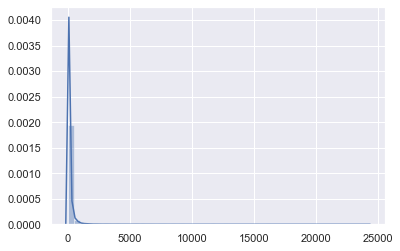

In [19]:
ax = sns.distplot(notes_lengths)

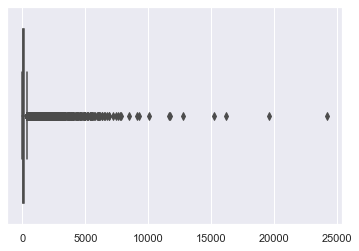

In [20]:
ax = sns.boxplot(x=notes_lengths)

In [21]:
len(notes_lengths[(notes_lengths<500) & (notes_lengths>7)])/len(dfObj)

0.9047791813714172

In [22]:
dfObj=dfObj[(notes_lengths<500) & (notes_lengths>7)]##get rid of notes that have more than 250 words

In [23]:
dfObj.shape

(27432, 2)

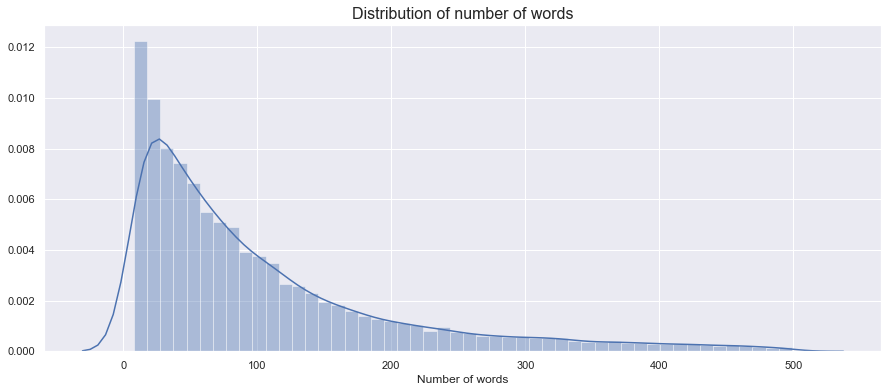

In [24]:
notes_lengths = np.array(list(map(len, dfObj.Next_Steps.str.split(' '))))
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(notes_lengths, bins=50, ax=ax);

In [25]:
print("There are {} documents with tops 5 words.".format(sum(notes_lengths <= 5)))

There are 0 documents with tops 5 words.


In [26]:
dfObj[notes_lengths <= 5]

,Next_Steps,output


#### Decide not to drop notes with few words becasue thet may contain useful infomation

27432


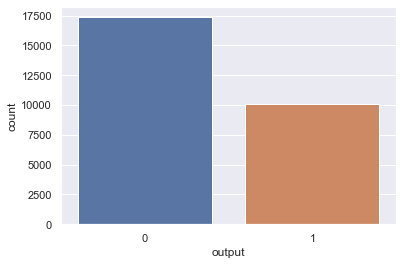

In [27]:
ax = sns.countplot(x="output", data=dfObj)
print(len(dfObj))

In [28]:
X=dfObj['Next_Steps']
y=dfObj['output']

In [29]:
dfObj['Next_Steps']

41                        4/29 - EVM - working to set EO| 
42       5/16 - EVM - spoke with the front desk and she...
43       04/06 YD demo done 27/05, quite complicated du...
44       09/05 YD Next step = call 15/05 2.30pm.\nDemo ...
45       09/05 YD demo done 6/05, interest in Expense +...
                               ...                        
11935    2/20 EF: Needed PO import added - send to CSM ...
11936    AD 2/20/19 - TT Frances (Controller) said she ...
11937    3/25 EF: Tier increase opp - email/call to DM,...
11938    MJ to JR \n\nprevious user, who is shopping ei...
11939    •\tName – Bob Patino (Controller) (heard about...
Name: Next_Steps, Length: 27432, dtype: object

In [30]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.summarization.textcleaner import tokenize_by_word
from gensim.summarization.textcleaner import clean_text_by_word
text=dfObj['Next_Steps'].values.tolist()
text=[strip_punctuation(str(t)) for t in text ]
text=[strip_non_alphanum(t) for t in text ]
text=[strip_numeric(t) for t in text ]
text=[remove_stopwords(t) for t in text ]
# text=[wd.decode('utf-8').split('/')[0] for wd in lemmatize(t) for t in text ]
text=[lemmatize(t) for t in text]


In [31]:
text2=[]
for i in text:
    temp=[]
    for j in i:
        temp.append(j.decode('utf-8').split('/')[0])
    text2.append(temp)   
text=[' '.join(t) for t in text2]

In [33]:
text2

[['evm', 'work', 'set', 'eo'],
 ['evm',
  'speak',
  'desk',
  'set',
  'time',
  'oliver',
  'wednesday',
  'invoice',
  'change',
  'internally',
  'interested',
  'explore',
  'concur',
  'loop',
  'rse',
  'time',
  'confirm'],
 ['yd',
  'demo',
  'complicate',
  'environment',
  'bug',
  'many',
  'competitor',
  'consult',
  'next',
  'step',
  'customer',
  'yd',
  'call',
  'mrs',
  'weis',
  'project',
  'hold',
  'current',
  'migration',
  'migration',
  'facturier',
  'priority',
  'expense',
  'meet',
  'competitor',
  'week',
  'compare',
  'feedback',
  'integration',
  'sae',
  'file',
  'send'],
 ['yd',
  'next',
  'step',
  'pm',
  'demo',
  'standard',
  'pro',
  'difference',
  'detail',
  'sap',
  'integration',
  'plu',
  'avoid',
  'implemnt',
  'faster',
  'flat',
  'file',
  'extrcat',
  'ledger',
  'file',
  'send',
  'technology',
  'integration',
  'whitepaper',
  'technical',
  'doc',
  'yd',
  'next',
  'step',
  'begin',
  'june',
  'demo',
  'standard',


In [34]:
dfObj['Next_Steps']=text 

In [35]:
dfObj.head()

,Next_Steps,output
41,evm work set eo,0
42,evm speak desk set time oliver wednesday invoi...,0
43,yd demo complicate environment bug many compet...,0
44,yd next step pm demo standard pro difference d...,0
45,yd demo expense expenseit receipt audit high d...,0


In [36]:
df_nw=dfObj[dfObj['output']==0]

In [37]:
df_nw.shape

(17376, 2)

In [38]:
X=dfObj['Next_Steps']
y=dfObj['output']

# 2) Feature creation 

In [39]:
from collections import Counter
import numpy as np 
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
TOKENS_ALPHANUMERIC = '[A-Za-z]+(?=\\s+)'
def freq_dist(data):
    """
    :param data: A string with sentences separated by '\n'
    :type data: str
    """
    
    ctv = CountVectorizer(analyzer='word',token_pattern=TOKENS_ALPHANUMERIC,
            ngram_range=(1, 2), stop_words = 'english')
    X = ctv.fit_transform(data.split('\n'))
    vocab = list(ctv.get_feature_names())
    counts = X.sum(axis=0).A1
    return ctv,Counter(dict(zip(vocab, counts)))

In [40]:
str_data=''.join(X.tolist())
ctv,cont=freq_dist(str_data)


In [41]:
cont.most_common()[:100]

[('send', 26686),
 ('week', 14038),
 ('email', 13313),
 ('eo', 12342),
 ('expense', 12321),
 ('set', 11821),
 ('demo', 11696),
 ('invoice', 11594),
 ('concur', 11043),
 ('month', 10710),
 ('follow', 10525),
 ('pricing', 9911),
 ('want', 9886),
 ('say', 9581),
 ('need', 8973),
 ('time', 8233),
 ('meeting', 7959),
 ('look', 7912),
 ('client', 7889),
 ('review', 7162),
 ('cfo', 7117),
 ('process', 6724),
 ('schedule', 6636),
 ('travel', 6283),
 ('team', 6115),
 ('ap', 5893),
 ('step', 5777),
 ('ask', 5646),
 ('sign', 5581),
 ('card', 5556),
 ('today', 5538),
 ('upside', 5294),
 ('report', 5287),
 ('sof', 5226),
 ('company', 5148),
 ('project', 4856),
 ('discuss', 4820),
 ('new', 4739),
 ('speak', 4704),
 ('update', 4572),
 ('april', 4558),
 ('customer', 4460),
 ('end', 4448),
 ('request', 4374),
 ('approval', 4298),
 ('confirm', 4193),
 ('decision', 4193),
 ('june', 4119),
 ('pm', 4087),
 ('forward', 4066),
 ('work', 4033),
 ('seek', 4017),
 ('set eo', 3969),
 ('controller', 3855),
 ('rea

In [42]:
##remove stop words accroding to term-frequency
stop_words.extend(['s','sap','said','t','th','tt'])##add stop words

In [43]:
y.shape

(27432,)

In [44]:
X.shape

(27432,)

In [45]:
X

41                                         evm work set eo
42       evm speak desk set time oliver wednesday invoi...
43       yd demo complicate environment bug many compet...
44       yd next step pm demo standard pro difference d...
45       yd demo expense expenseit receipt audit high d...
                               ...                        
11935    ef need po import add send csm docs sign ef cs...
11936    ad tt france controller say middle meeting set...
11937    ef tier increase opp email dm send docusign ma...
11938    mj jr previous user shopping sap erp oracle ne...
11939    name bob patino controller hear concur friend ...
Name: Next_Steps, Length: 27432, dtype: object

In [46]:
xtrain,xtest , ytrain, ytest = train_test_split(X, y,shuffle=True,random_state=27)

In [47]:
import dill
dill.dump_session('data_created.env')

In [48]:
import pickle
# Define the directories that contain the files downloaded
dir_cs = r'C:\Users\i516279\Desktop\NLP' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = dir_cs + "clean_data.pickle" # path to save cleaned data

In [49]:
# save the prepared data for modeling in next Phase.
pickle.dump( [xtrain,xtest, ytrain, ytest], open(pickle_file, "wb") )

# LDA

In [50]:
data_words=df_nw['Next_Steps'].values.tolist()
word_list=[i.split(' ') for i in data_words]

In [58]:
word_list[:10]

[['evm', 'work', 'set', 'eo'],
 ['evm',
  'speak',
  'desk',
  'set',
  'time',
  'oliver',
  'wednesday',
  'invoice',
  'change',
  'internally',
  'interested',
  'explore',
  'concur',
  'loop',
  'rse',
  'time',
  'confirm'],
 ['yd',
  'demo',
  'complicate',
  'environment',
  'bug',
  'many',
  'competitor',
  'consult',
  'next',
  'step',
  'customer',
  'yd',
  'call',
  'mrs',
  'weis',
  'project',
  'hold',
  'current',
  'migration',
  'migration',
  'facturier',
  'priority',
  'expense',
  'meet',
  'competitor',
  'week',
  'compare',
  'feedback',
  'integration',
  'sae',
  'file',
  'send'],
 ['yd',
  'next',
  'step',
  'pm',
  'demo',
  'standard',
  'pro',
  'difference',
  'detail',
  'sap',
  'integration',
  'plu',
  'avoid',
  'implemnt',
  'faster',
  'flat',
  'file',
  'extrcat',
  'ledger',
  'file',
  'send',
  'technology',
  'integration',
  'whitepaper',
  'technical',
  'doc',
  'yd',
  'next',
  'step',
  'begin',
  'june',
  'demo',
  'standard',


In [66]:
# Create Dictionary
id2word = corpora.Dictionary(word_list)

# Create Corpus
texts = word_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [67]:
[[(id2word[ids], freq) for ids, freq in cp] for cp in corpus[:5]]

[[('eo', 1), ('evm', 1), ('set', 1), ('work', 1)],
 [('evm', 1),
  ('set', 1),
  ('change', 1),
  ('concur', 1),
  ('confirm', 1),
  ('desk', 1),
  ('explore', 1),
  ('interested', 1),
  ('internally', 1),
  ('invoice', 1),
  ('loop', 1),
  ('oliver', 1),
  ('rse', 1),
  ('speak', 1),
  ('time', 2),
  ('wednesday', 1)],
 [('bug', 1),
  ('call', 1),
  ('compare', 1),
  ('competitor', 2),
  ('complicate', 1),
  ('consult', 1),
  ('current', 1),
  ('customer', 1),
  ('demo', 1),
  ('environment', 1),
  ('expense', 1),
  ('facturier', 1),
  ('feedback', 1),
  ('file', 1),
  ('hold', 1),
  ('integration', 1),
  ('many', 1),
  ('meet', 1),
  ('migration', 2),
  ('mrs', 1),
  ('next', 1),
  ('priority', 1),
  ('project', 1),
  ('sae', 1),
  ('send', 1),
  ('step', 1),
  ('week', 1),
  ('weis', 1),
  ('yd', 2)],
 [('work', 1),
  ('demo', 3),
  ('file', 6),
  ('integration', 6),
  ('next', 3),
  ('send', 3),
  ('step', 3),
  ('yd', 3),
  ('avoid', 3),
  ('begin', 2),
  ('detail', 3),
  ('differ

In [68]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [69]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.065*"expense" + 0.028*"report" + 0.027*"travel" + 0.024*"company" + '
  '0.024*"card" + 0.020*"look" + 0.017*"month" + 0.015*"concur" + 0.012*"use" '
  '+ 0.012*"user"'),
 (1,
  '0.031*"project" + 0.028*"finance" + 0.026*"meeting" + 0.025*"step" + '
  '0.020*"onsite" + 0.019*"week" + 0.014*"next" + 0.014*"customer" + '
  '0.014*"sap" + 0.012*"team"'),
 (2,
  '0.037*"eo" + 0.031*"invoice" + 0.030*"set" + 0.019*"say" + 0.018*"concur" + '
  '0.018*"time" + 0.016*"month" + 0.016*"process" + 0.014*"ap" + 0.014*"want"'),
 (3,
  '0.050*"send" + 0.032*"email" + 0.024*"follow" + 0.022*"pricing" + '
  '0.022*"week" + 0.020*"client" + 0.012*"need" + 0.012*"discuss" + '
  '0.012*"today" + 0.012*"review"'),
 (4,
  '0.101*"demo" + 0.077*"upside" + 0.069*"cfo" + 0.052*"schedule" + '
  '0.037*"controller" + 0.022*"complete" + 0.021*"step" + 0.018*"team" + '
  '0.018*"seek" + 0.016*"week"')]


In [71]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.316116159278437

Coherence Score:  0.5005503418495034


In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\i516279\AppData\Local\Anaconda\envs\Py36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.205230  0.071254       1        1  38.713226
3     -0.088869  0.257616       2        1  26.325951
0      0.300109 -0.150267       3        1  16.080746
1     -0.160066  0.078609       4        1  10.481878
4     -0.256403 -0.257212       5        1   8.398188, topic_info=     Category          Freq      Term         Total  loglift  logprob
26    Default   7104.000000      demo   7104.000000  30.0000  30.0000
28    Default   8678.000000   expense   8678.000000  29.0000  29.0000
42    Default  10917.000000      send  10917.000000  28.0000  28.0000
1843  Default   5380.000000    upside   5380.000000  27.0000  27.0000
73    Default   5052.000000       cfo   5052.000000  26.0000  26.0000
...       ...           ...       ...           ...      ...      ...
3172   Topic5    732.545776        ef   2976.991211   1.0750  -4.5631
59     Topic5    653.731262      june   2335.188965   1.2040  -4.6769
466    Topic5    513.145569  timeline   1853.776611   1.1927  -4.9190
423    Topic5    422.430023     early   1187.780273   1.4433  -5.1136
40     Topic5    476.637024   project   4298.713867   0.2778  -4.9928

[290 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
326       1  0.397501  account
326       2  0.193928  account
326       3  0.380748  account
326       4  0.027414  account
285       2  0.872171      add
...     ...       ...      ...
325       4  0.036816  working
325       5  0.424966  working
391       1  0.899411     year
391       3  0.033056     year
391       4  0.067592     year

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])

# Building Basic Models

In [86]:
from sklearn.metrics import classification_report

In [83]:
TOKENS_ALPHANUMERIC = '[A-Za-z]+(?=\\s+)'
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=1000, ###update
            strip_accents='unicode', analyzer='word',token_pattern=TOKENS_ALPHANUMERIC,
            ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = stop_words)

# Fitting TF-IDF to training 
tfv.fit(list(xtrain))
xtrain_tfv =  tfv.transform(xtrain) 
xtest_tfv = tfv.transform(xtest)

In [141]:
len(tfv.get_feature_names())

1000

In [142]:
from imblearn.over_sampling import SMOTE

# setting up testing and training sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

sm = SMOTE(random_state=27, ratio=1.0)
smX_train_tft, smy_train_ftv = sm.fit_sample(xtrain_tfv, ytrain)

In [143]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='stratified')
dummy.fit(xtrain_tfv, ytrain)
ypredict = dummy.predict(xtest_tfv)
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63      4342
           1       0.36      0.36      0.36      2516

    accuracy                           0.53      6858
   macro avg       0.50      0.50      0.50      6858
weighted avg       0.53      0.53      0.53      6858



In [144]:
# Fitting a simple Logistic Regression on TFIDF without smote
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xtest_tfv)
ypredict = clf.predict(xtest_tfv)

print(classification_report(ytest, ypredict))

C:\Users\i516279\AppData\Local\Anaconda\envs\Py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.85      0.90      0.88      4342
           1       0.82      0.73      0.77      2516

    accuracy                           0.84      6858
   macro avg       0.84      0.82      0.83      6858
weighted avg       0.84      0.84      0.84      6858



In [145]:
from sklearn.model_selection import GridSearchCV
tuned_parameters={'penalty': ['l1', 'l2'],'C':[0.01,.05,1,5,10,15,20,25,30]}
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=5)
clf.fit(xtrain_tfv, ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(xtest_tfv)
print(classification_report(y_true, y_pred))
print()

C:\Users\i516279\AppData\Local\Anaconda\envs\Py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best parameters set found on development set:

{'C': 1, 'penalty': 'l1'}

Grid scores on development set:

0.665 (+/-0.004) for {'C': 0.01, 'penalty': 'l1'}
0.740 (+/-0.007) for {'C': 0.01, 'penalty': 'l2'}
0.808 (+/-0.012) for {'C': 0.05, 'penalty': 'l1'}
0.818 (+/-0.008) for {'C': 0.05, 'penalty': 'l2'}
0.849 (+/-0.012) for {'C': 1, 'penalty': 'l1'}
0.848 (+/-0.011) for {'C': 1, 'penalty': 'l2'}
0.847 (+/-0.008) for {'C': 5, 'penalty': 'l1'}
0.848 (+/-0.008) for {'C': 5, 'penalty': 'l2'}
0.844 (+/-0.007) for {'C': 10, 'penalty': 'l1'}
0.846 (+/-0.007) for {'C': 10, 'penalty': 'l2'}
0.844 (+/-0.005) for {'C': 15, 'penalty': 'l1'}
0.845 (+/-0.006) for {'C': 15, 'penalty': 'l2'}
0.843 (+/-0.005) for {'C': 20, 'penalty': 'l1'}
0.845 (+/-0.006) for {'C': 20, 'penalty': 'l2'}
0.843 (+/-0.004) for {'C': 25, 'penalty': 'l1'}
0.844 (+/-0.006) for {'C': 25, 'penalty': 'l2'}
0.843 (+/-0.004) for {'C': 30, 'penalty': 'l1'}
0.844 (+/-0.007) for {'C': 30, 'penalty': 'l2'}

Detailed classification 

#### Becasue it doesn't change much so we will not bother using SMOTE

In [64]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)

ypredict = clf.predict(xtest_tfv)

print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      4342
           1       0.83      0.61      0.70      2516

    accuracy                           0.81      6858
   macro avg       0.82      0.77      0.78      6858
weighted avg       0.81      0.81      0.80      6858



In [65]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(MultinomialNB(), param_grid=dict(alpha=np.linspace(0,2,20)[1:]), cv=5)
clf.fit(xtrain_tfv, ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(xtest_tfv)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'alpha': 0.3157894736842105}

Grid scores on development set:

0.822 (+/-0.008) for {'alpha': 0.10526315789473684}
0.823 (+/-0.010) for {'alpha': 0.21052631578947367}
0.824 (+/-0.011) for {'alpha': 0.3157894736842105}
0.823 (+/-0.011) for {'alpha': 0.42105263157894735}
0.823 (+/-0.009) for {'alpha': 0.5263157894736842}
0.823 (+/-0.008) for {'alpha': 0.631578947368421}
0.821 (+/-0.007) for {'alpha': 0.7368421052631579}
0.819 (+/-0.008) for {'alpha': 0.8421052631578947}
0.816 (+/-0.007) for {'alpha': 0.9473684210526315}
0.815 (+/-0.008) for {'alpha': 1.0526315789473684}
0.813 (+/-0.005) for {'alpha': 1.1578947368421053}
0.810 (+/-0.005) for {'alpha': 1.263157894736842}
0.808 (+/-0.006) for {'alpha': 1.3684210526315788}
0.806 (+/-0.005) for {'alpha': 1.4736842105263157}
0.804 (+/-0.004) for {'alpha': 1.5789473684210527}
0.803 (+/-0.005) for {'alpha': 1.6842105263157894}
0.801 (+/-0.004) for {'alpha': 1.789473684210526}
0.800 (+/-0.005) for {

# SVM

In [80]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xtest_svd)

In [82]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)

ypredict = clf.predict(xvalid_svd_scl)
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4342
           1       0.82      0.75      0.79      2516

    accuracy                           0.85      6858
   macro avg       0.84      0.83      0.83      6858
weighted avg       0.85      0.85      0.85      6858



In [146]:
kernels = ['linear','rbf']
gammas = [0.1, 1, 10]
cs = [0.1, 1, 10]
param_grid = {'kernel': kernels,'C':cs,'gamma':gammas}

clf = GridSearchCV( SVC(), param_grid=param_grid, cv=5)
clf.fit(xtrain_tfv, ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(xtest_tfv)
print(classification_report(y_true, y_pred))
print()

Best parameters set found on development set:

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.843 (+/-0.008) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
0.802 (+/-0.010) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.843 (+/-0.008) for {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
0.824 (+/-0.009) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.843 (+/-0.008) for {'C': 0.1, 'gamma': 10, 'kernel': 'linear'}
0.635 (+/-0.001) for {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
0.850 (+/-0.012) for {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
0.847 (+/-0.008) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.850 (+/-0.012) for {'C': 1, 'gamma': 1, 'kernel': 'linear'}
0.855 (+/-0.013) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.850 (+/-0.012) for {'C': 1, 'gamma': 10, 'kernel': 'linear'}
0.654 (+/-0.006) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.848 (+/-0.013) for {'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
0.852 (+/-0.013) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.84

# xgboost

In [84]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier()
clf.fit(xtrain_tfv, ytrain)
# predictions = clf.predict_proba(xvalid_svd_scl.tocsc())
ypredict = clf.predict(xtest_tfv)
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      4342
           1       0.83      0.65      0.73      2516

    accuracy                           0.82      6858
   macro avg       0.82      0.79      0.80      6858
weighted avg       0.82      0.82      0.82      6858



In [147]:


grid_values = {'learning_rate': [0.01,0.05,0.1],'gamma':[0.1, 1, 10, 100],'max_depth':[4,6,8,10],'n_estimators':[100,200]}



clf = GridSearchCV( xgb.XGBClassifier(objective='binary:logistic'), param_grid=grid_values, cv=5)
clf.fit(xtrain_tfv, ytrain)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = ytest, clf.predict(xtest_tfv)
print(classification_report(y_true, y_pred))
print()



Best parameters set found on development set:

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}

Grid scores on development set:

0.788 (+/-0.019) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
0.804 (+/-0.017) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200}
0.804 (+/-0.019) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
0.817 (+/-0.015) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
0.815 (+/-0.017) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}
0.828 (+/-0.016) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 200}
0.819 (+/-0.015) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
0.830 (+/-0.013) for {'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
0.823 (+/-0.011) for {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 4, '

# Doc2Vec

In [85]:
X

41                                         evm work set eo
42       evm speak desk set time oliver wednesday invoi...
43       yd demo complicate environment bug many compet...
44       yd next step pm demo standard pro difference d...
45       yd demo expense expenseit receipt audit high d...
                               ...                        
11935    ef need po import add send csm docs sign ef cs...
11936    ad tt france controller say middle meeting set...
11937    ef tier increase opp email dm send docusign ma...
11938    mj jr previous user shopping sap erp oracle ne...
11939    name bob patino controller hear concur friend ...
Name: Next_Steps, Length: 27432, dtype: object

In [86]:
model = gensim.models.Word2Vec(text2, size=100, min_count=1)


In [87]:
model.save('fname')
model = Word2Vec.load('fname')

In [88]:
word_count=list(model.wv.vocab)
print("There are %d words" %len(word_count) )

There are 25935 words


In [89]:
model.most_similar('concur')

[('platform', 0.6601778268814087),
 ('product', 0.65467369556427),
 ('solution', 0.6330243349075317),
 ('expensify', 0.5902121663093567),
 ('experience', 0.5860270261764526),
 ('avid', 0.5827707052230835),
 ('tool', 0.582342267036438),
 ('benefit', 0.5817465782165527),
 ('willing', 0.5797823667526245),
 ('fully', 0.5755491852760315)]

In [90]:
model.wv.syn0.shape

(25935, 100)

In [91]:
df2Vec=dfObj

In [92]:
df2Vec['tokens']=text2

In [93]:
df2Vec.head()

,Next_Steps,output,tokens
41,evm work set eo,0,"[evm, work, set, eo]"
42,evm speak desk set time oliver wednesday invoi...,0,"[evm, speak, desk, set, time, oliver, wednesda..."
43,yd demo complicate environment bug many compet...,0,"[yd, demo, complicate, environment, bug, many,..."
44,yd next step pm demo standard pro difference d...,0,"[yd, next, step, pm, demo, standard, pro, diff..."
45,yd demo expense expenseit receipt audit high d...,0,"[yd, demo, expense, expenseit, receipt, audit,..."


In [94]:
Xtrain,Xtest, ytrain, ytest = train_test_split(df2Vec['tokens'], df2Vec['output'],shuffle=True,random_state=27)

In [95]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2Vec, test_size=.30, random_state=27)
#Tag train set
tagged_tr = [TaggedDocument(words=_d,
tags=[str(i)]) for i, _d in enumerate(train.tokens)]
# #Tag test set
tagged_test = [TaggedDocument(words=_d,
tags=[str(i)]) for i, _d in enumerate(test.tokens)]

In [96]:
tagged_tr

[TaggedDocument(words=['cc', 'arr', 'isr', 'run', 'oppt', 'cc', 'arr', 'isr', 'run', 'oppt', 'cc', 'arr', 'isr', 'run', 'oppt', 'cc', 'arr', 'isr', 'run', 'oppt'], tags=['0']),
 TaggedDocument(words=['ds', 'call', 'note', 'location', 'scan', 'send', 'invoice', 'corporate', 'office', 'corporate', 'office', 'easily', 'go', 'invoice', 'month', 'do', 'recognize', 'current', 'erp', 'ts', 'follow', 'eom', 'interested', 'busy', 'let', 'reconnect', 'audit', 'come', 'new', 'store', 'open', 'wont', 'able', 'work', 'april', 'thank', 'judy', 'brown', 'controller', 'toojay', 'deli', 'bakery', 'restaurant', 'georgia', 'ave', 'west', 'palm', 'beach', 'fl', 'office', 'ext', 'cell', 'want', 'reach', 'update', 'process', 'evaluate', 'travel', 'provider', 'american', 'express', 'work', 'concur', 'prefer', 'book', 'tool', 'demo', 'scheduled', 'week', 'determine', 'price', 'best', 'fit', 'company', 'make', 'final', 'decision', 'expense', 'reimbursement', 'travel', 'program', 'evaluation', 'complete', 'mean

In [97]:
model = Doc2Vec(vector_size=300,
                alpha=.025, 
                min_alpha=0.00025, 
                min_count=1, 
                dm=1, 
                workers=8)
model.build_vocab(tagged_tr)

In [98]:
epochs = range(100)
for epoch in epochs:
    print(f'Epoch {epoch+1}')
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.00025
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
     
model.save('math_lectures.model')

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100


In [99]:
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train['output']

In [100]:
X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test['output']

In [101]:
X_test = np.array([model.docvecs[str(i)] for i in range(len(tagged_test))])
y_test = test['output']

In [102]:
X_test

array([[ 1.012849  ,  0.3362858 ,  0.87071407, ...,  0.33969358,
         0.06115144, -0.11417268],
       [-1.4860696 , -0.46368447,  0.02566019, ...,  1.3174694 ,
        -3.2659717 ,  2.615424  ],
       [ 0.27067003, -0.7744173 , -0.39471877, ..., -0.00647805,
         0.2851845 ,  0.3407598 ],
       ...,
       [ 1.4667776 ,  0.17534578,  0.20642444, ...,  1.2537729 ,
        -2.192485  ,  1.3395267 ],
       [ 0.5260443 , -2.7481549 ,  0.14017569, ...,  2.0041528 ,
         1.2199281 , -1.8316679 ],
       [ 1.5104883 ,  1.9978161 ,  0.7548127 , ...,  1.1804096 ,
         0.43304977,  0.7480862 ]], dtype=float32)

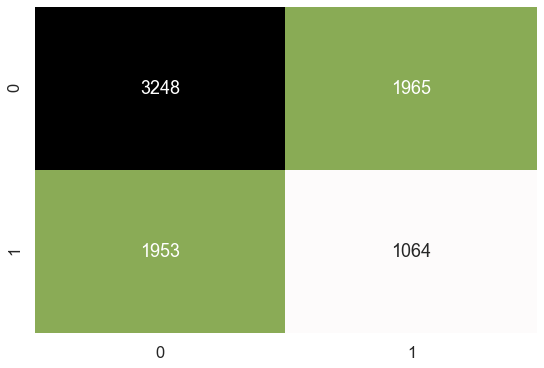

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      5213
           1       0.35      0.35      0.35      3017

    accuracy                           0.52      8230
   macro avg       0.49      0.49      0.49      8230
weighted avg       0.52      0.52      0.52      8230



In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))
#Fit and predict

clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, y_train)

ypredict = clf.predict(X_test)
# print(classification_report(y_test, ypredict))

# lrc = LogisticRegression(C=3.0)
# lrc.fit(X_train,y_train)
# ypredict = lrc.predict(X_test)
# print(classification_report(y_test, ypredict))
heatconmat(y_test,ypredict)

In [104]:
y_test[y_test==1].count()

3017

In [105]:
len(tagged_test)

8230

In [106]:
y_train[y_train == 0].count()

12163

In [107]:
y_test[y_test==0].shape

(5213,)

# Fast.ai on tf-idf

In [55]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
from functools import partial
import io
import os

In [52]:
dfObj.head()

,Next_Steps,output
41,evm work set eo,0
42,evm speak desk set time oliver wednesday invoi...,0
43,yd demo complicate environment bug many compet...,0
44,yd next step pm demo standard pro difference d...,0
45,yd demo expense expenseit receipt audit high d...,0


In [51]:
df = pd.DataFrame({'label':dfObj.output, 'text':dfObj.Next_Steps})

In [53]:
df_trn, df_val = train_test_split(df, stratify = df['label'], random_state = 27)

In [56]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [60]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [68]:
learn2 = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [61]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.368095,6.018281,0.102396,1:00:54


In [69]:
learn2.fit_one_cycle(1, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,6.314982,5.972636,0.105335,1:01:16


In [62]:
learn.save_encoder('ft_enc')

In [70]:
learn2.save_encoder('ft_enc')

In [64]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

In [71]:
learn2 = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn2.load_encoder('ft_enc')

In [65]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.461461,0.373429,0.843540,33:07


In [72]:
learn2.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.426984,0.364185,0.849373,18:26:28


In [66]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
0,3964,693
1,380,1821


In [77]:
learn.predict(''''Learned from XXX about how much time it takes to create expense reports in her company currently
She is interested in Concur Expense cost and service in general. Discussed about discount to retain business and earn the right to sell invoice.| Set a task to follow up  
3/22 - Emailed XXX to check if she's ready to get CI and Extract Services added today.|
3/22 - Sent DS to XXX''')

C:\Users\i516279\AppData\Local\Anaconda\envs\Py36\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category 0, tensor(0), tensor([0.8308, 0.1692]))

### LSTM
##### https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [112]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts((dfObj['Next_Steps'].values))

print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 25931 unique tokens.


In [113]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(dfObj['Next_Steps'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (27432, 250)


In [114]:
Y = pd.get_dummies(dfObj['output']).values

In [129]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 27)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(20574, 250) (20574, 2)
(6858, 250) (6858, 2)


In [136]:


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 40
batch_size = 100

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 18516 samples, validate on 2058 samples
Epoch 1/40
18516/18516 [==============================] - ETA: 8:08 - loss: 0.6925 - acc: 0.510 - ETA: 5:42 - loss: 0.6912 - acc: 0.585 - ETA: 4:47 - loss: 0.6895 - acc: 0.603 - ETA: 4:19 - loss: 0.6870 - acc: 0.622 - ETA: 4:01 - loss: 0.6840 - acc: 0.638 - ETA: 3:51 - loss: 0.6817 - acc: 0.636 - ETA: 3:45 - loss: 0.6810 - acc: 0.622 - ETA: 3:39 - loss: 0.6806 - acc: 0.611 - ETA: 3:34 - loss: 0.6797 - acc: 0.605 - ETA: 3:31 - loss: 0.6756 - acc: 0.611 - ETA: 3:28 - loss: 0.6714 - acc: 0.615 - ETA: 3:25 - loss: 0.6671 - acc: 0.619 - ETA: 3:22 - loss: 0.6667 - acc: 0.616 - ETA: 3:20 - loss: 0.6623 - acc: 0.618 - ETA: 3:17 - loss: 0.6590 - acc: 0.620 - ETA: 3:16 - loss: 0.6569 - acc: 0.618 - ETA: 3:14 - loss: 0.6499 - acc: 0.626 - ETA: 3:13 - loss: 0.6472 - acc: 0.626 - ETA: 3:11 - loss: 0.6465 - acc: 0.623 - ETA: 3:09 - loss: 0.6413 - acc: 0.628 - ETA: 3:09 - loss: 0.6368 - acc: 0.631 - ETA: 3:08 - loss: 0.6321 - acc: 0.635 - ETA: 3:06 - l

18516/18516 [==============================] - ETA: 4:28 - loss: 0.1610 - acc: 0.950 - ETA: 4:38 - loss: 0.1491 - acc: 0.950 - ETA: 4:50 - loss: 0.1461 - acc: 0.953 - ETA: 4:45 - loss: 0.1445 - acc: 0.957 - ETA: 4:38 - loss: 0.1679 - acc: 0.952 - ETA: 4:40 - loss: 0.1825 - acc: 0.945 - ETA: 4:36 - loss: 0.2024 - acc: 0.934 - ETA: 4:34 - loss: 0.2051 - acc: 0.930 - ETA: 4:39 - loss: 0.2047 - acc: 0.928 - ETA: 4:38 - loss: 0.2024 - acc: 0.926 - ETA: 4:32 - loss: 0.2016 - acc: 0.926 - ETA: 4:34 - loss: 0.1963 - acc: 0.929 - ETA: 4:38 - loss: 0.1972 - acc: 0.929 - ETA: 4:39 - loss: 0.1968 - acc: 0.927 - ETA: 4:36 - loss: 0.1988 - acc: 0.925 - ETA: 4:36 - loss: 0.1940 - acc: 0.926 - ETA: 4:36 - loss: 0.1980 - acc: 0.926 - ETA: 4:34 - loss: 0.1930 - acc: 0.927 - ETA: 4:33 - loss: 0.1910 - acc: 0.926 - ETA: 4:33 - loss: 0.1876 - acc: 0.928 - ETA: 4:33 - loss: 0.1905 - acc: 0.927 - ETA: 4:34 - loss: 0.1924 - acc: 0.925 - ETA: 4:33 - loss: 0.1883 - acc: 0.927 - ETA: 4:34 - loss: 0.1881 - acc: 0

18516/18516 [==============================] - ETA: 4:20 - loss: 0.1180 - acc: 0.950 - ETA: 3:58 - loss: 0.1184 - acc: 0.955 - ETA: 3:52 - loss: 0.1324 - acc: 0.946 - ETA: 3:47 - loss: 0.1282 - acc: 0.952 - ETA: 3:43 - loss: 0.1344 - acc: 0.952 - ETA: 3:44 - loss: 0.1496 - acc: 0.950 - ETA: 3:43 - loss: 0.1568 - acc: 0.945 - ETA: 3:42 - loss: 0.1489 - acc: 0.948 - ETA: 3:41 - loss: 0.1484 - acc: 0.951 - ETA: 3:42 - loss: 0.1449 - acc: 0.951 - ETA: 3:44 - loss: 0.1430 - acc: 0.950 - ETA: 3:47 - loss: 0.1425 - acc: 0.950 - ETA: 3:50 - loss: 0.1449 - acc: 0.947 - ETA: 3:48 - loss: 0.1413 - acc: 0.950 - ETA: 3:47 - loss: 0.1401 - acc: 0.949 - ETA: 3:46 - loss: 0.1396 - acc: 0.949 - ETA: 3:44 - loss: 0.1377 - acc: 0.950 - ETA: 3:43 - loss: 0.1369 - acc: 0.951 - ETA: 3:41 - loss: 0.1351 - acc: 0.952 - ETA: 3:40 - loss: 0.1336 - acc: 0.952 - ETA: 3:38 - loss: 0.1332 - acc: 0.952 - ETA: 3:36 - loss: 0.1319 - acc: 0.953 - ETA: 3:34 - loss: 0.1318 - acc: 0.953 - ETA: 3:33 - loss: 0.1312 - acc: 0

In [132]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6858/6858 [==============================] - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [133]:
accr

[0.33190513383754666, 0.8673082531524073]

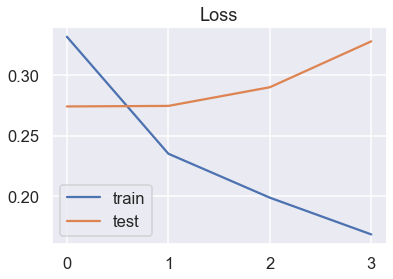

In [134]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

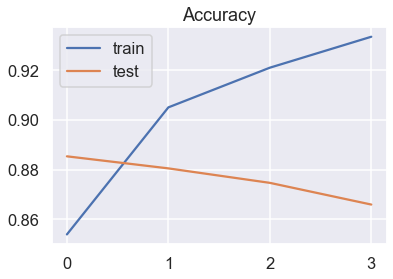

In [135]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# Test

In [121]:
new_notes = ['This client has already have an expense in their company.']
seq = tokenizer.texts_to_sequences(new_notes)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
y_classes = pred.argmax(axis=-1)

print(pred)
print(y_classes)

[[0.9135359  0.08646412]]
[0]


In [122]:
new_notes = ['''CFO is interested in Concur product and would like to learn more. A follow-up call has been scheduled. Will stay in connect with the CEO''']
seq = tokenizer.texts_to_sequences(new_notes)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
y_classes = pred.argmax(axis=-1)

print(pred)
print(y_classes)

[[0.9600854  0.03991454]]
[0]


In [123]:
new_notes = ['''Learned from XXX about how much time it takes to create expense reports in her company currently
She is interested in Concur Expense cost and service in general. Discussed about discount to retain business and earn the right to sell invoice.| Set a task to follow up  
3/22 - Emailed XXX to check if she's ready to get CI and Extract Services added today.|
3/22 - Sent DS to XXX. ''']
seq = tokenizer.texts_to_sequences(new_notes)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
y_classes = pred.argmax(axis=-1)

print(pred)
print(y_classes)

[[0.637709   0.36229104]]
[0]


# anvil Web

In [73]:
import anvil.server

anvil.server.connect("7CNPRLY55PQXEO24GT4ABXZR-74LVIULUNWCDMWNL")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Authenticated OK
Anvil server output: You're using the Anvil Free plan. Upgrade at https://anvil.works/


In [87]:
# Fitting a simple xgboost on tf-idf
best_clf = xgb.XGBClassifier(objective='binary:logistic',gamma= 1, learning_rate= 0.1, max_depth= 10, n_estimators= 200)
best_clf.fit(xtrain_tfv, ytrain)
# predictions = clf.predict_proba(xvalid_svd_scl.tocsc())
ypredict = best_clf.predict(xtest_tfv)
print(classification_report(ytest, ypredict))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4342
           1       0.81      0.74      0.78      2516

    accuracy                           0.84      6858
   macro avg       0.84      0.82      0.83      6858
weighted avg       0.84      0.84      0.84      6858



In [89]:
ypredict = best_clf.predict_proba(xtest_tfv)

In [91]:
ypredict[1][0]

0.99714917

In [93]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.summarization.textcleaner import tokenize_by_word
from gensim.summarization.textcleaner import clean_text_by_word


In [110]:
@anvil.server.callable
def notesClassification(text):
    import numpy as np
    text=[strip_punctuation(str(t)) for t in text ]
    text=[strip_non_alphanum(t) for t in text ]
    text=[strip_numeric(t) for t in text ]
    text=[remove_stopwords(t) for t in text ]
    # text=[wd.decode('utf-8').split('/')[0] for wd in lemmatize(t) for t in text ]
    text=[lemmatize(t) for t in text]
    text2=[]
    for i in text:
        temp=[]
        for j in i:
            temp.append(j.decode('utf-8').split('/')[0])
        text2.append(temp)   
    text=[' '.join(t) for t in text2]
    xtest_tfv =  tfv.transform(text) 
    prediction=best_clf.predict_proba(xtest_tfv)
    return ('The probability for this opportunity to win is %.2f'%prediction[0][1])
        
    